In [1]:
#Importing all the neccesary libraries
import numpy as np 
import pandas as pd 
import csv

import os
print(os.listdir("input"))

import regex as re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
# from wordcloud import WordCloud

# viz
import matplotlib.pyplot as plt
%matplotlib inline
import sys

# for clustering
from scipy.cluster.hierarchy import ward, dendrogram, fcluster, single, complete, average, weighted
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import squareform
from sklearn.metrics import silhouette_score

['.ipynb_checkpoints', 'Bug report.csv', 'JIRA-ALL.csv', 'JIRA-BUG.csv', 'mozilla_firefox']


In [2]:
data=pd.read_csv('Input/JIRA-BUG.csv')
data = data.reset_index()

In [3]:
cols_of_interest=["Summary", "Status","Description","Priority","Resolution", "Issue Type", "Bug Location"]
data=data[cols_of_interest]
print(data.shape)
data.head()

(651, 7)


,Summary,Status,Description,Priority,Resolution,Issue Type,Bug Location
0,[Dev][Demo][Admin Portal][Edit Bundle items]: ...,To Do,This issue occurs on *Add new bundle items.*\n...,P1,NaN,Bug,Admin Portal
1,[Dev][Admin Portal][Create New][Create From ex...,In Progress,This issue occurs on Create new Role and Creat...,P1,NaN,Bug,Admin Portal
2,Duplicate items while using Search items by ke...,To Do,"While making script for cleanup, we found that...",P2,NaN,Bug,Automation Test
3,[AP] Default language and default region of st...,QA,When we open Stores menu and look at the store...,P1,NaN,Bug,Admin Portal
4,[Unity][SDK] Single draft store makes subscrip...,To Do,The restriction of single draft store makes su...,P1,NaN,Bug,SDK


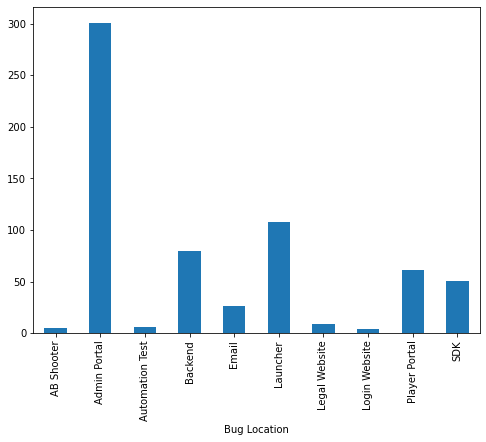

In [4]:
fig = plt.figure(figsize=(8,6))
data.groupby('Bug Location').Status.count().plot.bar(ylim=0)
plt.show()

In [5]:
data.Description = data.Description.fillna("0")
data.isnull().sum()

Summary          0
Status           0
Description      0
Priority         0
Resolution      97
Issue Type       0
Bug Location     0
dtype: int64

In [6]:
data.isnull().sum()

Summary          0
Status           0
Description      0
Priority         0
Resolution      97
Issue Type       0
Bug Location     0
dtype: int64

**Text data preprocessing steps**

1- Data Cleaning(either using regex or BeautifulSoup): 
a) Removing HTML characters. 
b) Removing punctuation. 
c) Decoding encoded data.
d) Split attached words.
e) Removing URLs. 
f) Apostrophe removal.
g) Removing Expressions. 
h) Uppercase & Lowercase letters 
i) Numbers such as amounts and data.

2- Data Tokenization(using word_tokenize in nltk.tokenize) 
Segregation of text into individual words i.e tokens.

3- Stopword Removal(using stopwords in nltk.corpus)
Discarding too common words or words which are not going to be helpful in our analysis.

4- Stemming(using WordNetLemmatizer in nltk.stem) 
Combining different variants of words into a single parent word that conveys same meaning.

In [7]:
stops = set(stopwords.words("english"))

In [8]:
data['Concat'] = data.Summary +" "+ data.Description+" "+data["Bug Location"]
data.to_csv("./Output/data_concat.csv")

In [9]:
def clean_Description(content):
#     content = table.Description
    #Converting text to lowercase characters
    content = content.apply(lambda x: x.lower())
    #Removing HTML tags
    content = content.apply(lambda x: re.sub(r'\<[^<>]*\>','',x))
    #Removing any character which does not match to letter,digit or underscore
    content = content.apply(lambda x: re.sub(r'^\W+|\W+$',' ',x))
    #Removing space,newline,tab
    content = content.apply(lambda x: re.sub(r'\s',' ',x))
    #Removing punctuation
    content = content.apply(lambda x: re.sub(r'[^a-zA-Z0-9]',' ',x))
    #Removing numeric
    content = content.apply(lambda x: re.sub(r'[0-9]','',x))
    #Tokenizing data
    content = content.apply(lambda x: word_tokenize(x))
    #Removing stopwords
    content = content.apply(lambda x: [i for i in x if i not in stops])
    type(content)
    return(content)

In [10]:
dataClean = pd.DataFrame()
data['Concat'] = clean_Description(data['Concat'])
dataClean['Concat'] = data['Concat']

In [11]:
dataClean.head()

,Concat
0,"[dev, demo, portal, edit, bundle, items, add, ..."
1,"[dev, portal, create, new, create, existing, a..."
2,"[duplicate, items, using, search, items, keywo..."
3,"[ap, default, language, default, region, store..."
4,"[unity, sdk, single, draft, store, makes, subs..."


## Stemming

In [12]:
data.dtypes

Summary         object
Status          object
Description     object
Priority        object
Resolution      object
Issue Type      object
Bug Location    object
Concat          object
dtype: object

In [13]:
wordnet = WordNetLemmatizer()
dataClean.Concat = dataClean.Concat.apply(lambda x:[wordnet.lemmatize(i,pos='v') for i in x])

In [14]:
dataClean['Concat'] = dataClean['Concat'].astype(str)
dataClean['Concat'] = dataClean['Concat'].apply(lambda x: re.sub(r'\s',' ',x))
dataClean['Concat'] = dataClean['Concat'].apply(lambda x: re.sub(r'[^a-zA-Z0-9]',' ',x))
dataClean['Concat'] = dataClean['Concat'].apply(lambda x: re.sub(r'^\W+|\W+$',' ',x))

In [15]:
dataClean.head()
dataClean.to_csv("./Output/token_concat.csv")

In [16]:
from nltk.util import everygrams
def ngramconvert(df,n=2,col=""):
    for item in df.columns:
        df[col]=df[item].apply(lambda sentence: list(everygrams(sentence.split(), max_len=n)))
    return df

In [17]:
new_df = ngramconvert(dataClean,2,"nGram")
new_df.head()

,Concat,nGram
0,dev demo portal edit bundle it...,"[(dev,), (demo,), (portal,), (edit,), (bundle,..."
1,dev portal create new create e...,"[(dev,), (portal,), (create,), (new,), (create..."
2,duplicate items use search items ...,"[(duplicate,), (items,), (use,), (search,), (i..."
3,ap default language default regio...,"[(ap,), (default,), (language,), (default,), (..."
4,unity sdk single draft store m...,"[(unity,), (sdk,), (single,), (draft,), (store..."


In [18]:
dataClean.head()

,Concat,nGram
0,dev demo portal edit bundle it...,"[(dev,), (demo,), (portal,), (edit,), (bundle,..."
1,dev portal create new create e...,"[(dev,), (portal,), (create,), (new,), (create..."
2,duplicate items use search items ...,"[(duplicate,), (items,), (use,), (search,), (i..."
3,ap default language default regio...,"[(ap,), (default,), (language,), (default,), (..."
4,unity sdk single draft store m...,"[(unity,), (sdk,), (single,), (draft,), (store..."


In [19]:
# desc = ' '
# for x in data.Concat:
#     for y in x:
#         desc+=' '+y

In [20]:
# plt.figure(figsize=(8,10))
# wc = WordCloud(max_words=1000,random_state=1).generate(desc)
# plt.imshow(wc)
# plt.show()

In [21]:
Summary = dataClean.Concat.astype(str)
listOfSummary = dataClean.nGram

In [22]:
listOfSummary

0      [(dev,), (demo,), (portal,), (edit,), (bundle,...
1      [(dev,), (portal,), (create,), (new,), (create...
2      [(duplicate,), (items,), (use,), (search,), (i...
3      [(ap,), (default,), (language,), (default,), (...
4      [(unity,), (sdk,), (single,), (draft,), (store...
                             ...                        
646    [(stg,), (launcher,), (launcher,), (start,), (...
647    [(stg,), (launcher,), (set,), (revert,), (last...
648    [(stg,), (ap,), (portal,), (feature,), (conten...
649    [(stg,), (ap,), (option,), (update,), (client,...
650    [(backend,), (get,), (use,), (different,), (na...
Name: nGram, Length: 651, dtype: object

# Hiearchical Clustering

## Jaccard Coeffient

In [23]:
import itertools
def compute_jaccard(str1, str2):
    himpunan1 = set(str1)
    himpunan2 = set(str2)
    irisan = himpunan1.intersection(himpunan2)
    gabungan = himpunan1.union(himpunan2)
    jaccard = len(irisan)/float(len(gabungan))
    
    return jaccard

In [24]:
sim_df = pd.DataFrame()

for col_pair in itertools.combinations_with_replacement(listOfSummary,2):
    strOfCol = str(col_pair)
    
    u0 = col_pair[0]
    u1 = col_pair[1]
    sim_df.loc[str(col_pair[0]), str(col_pair[1])] = compute_jaccard(u0, u1)

In [25]:
np.savetxt("./Output/distance_matrix_before_fillna.csv", np.array(sim_df), delimiter=",")

In [26]:
sim_df = sim_df.fillna(0)

In [27]:
dist = np.array(sim_df)
print(dist)

[[1.         0.16239316 0.01360544 ... 0.02631579 0.03614458 0.01538462]
 [0.         1.         0.02884615 ... 0.03636364 0.04       0.00645161]
 [0.         0.         1.         ... 0.00793651 0.0141844  0.02424242]
 ...
 [0.         0.         0.         ... 1.         0.2195122  0.07317073]
 [0.         0.         0.         ... 0.         1.         0.06666667]
 [0.         0.         0.         ... 0.         0.         1.        ]]


In [28]:
# ndist = dist[:, ~np.isnan(dist).any(axis=0)]
# # print(ndist)

In [29]:
np.savetxt("./Output/distance_matrix.csv", dist, delimiter=",")

## Agglomerative Hierarchical Clustering

In [30]:
linkage_matrix = weighted(dist) # replace with complete, single, or other scipy.cluster.hierarchical algorithms

## Visualization

Dendrogram visualization. We visualize the titles of each paper next to the corresponding leaf to qualitatively evaluate the clustering.

Changing the `color_threshold` kwarg in the call to `dendrogram()` will affect how the clusters are displayed by increasing or decreasing the 
minimum distance necessary for `dendrogram()` to color a cluster differently.

In [31]:
# sys.setrecursionlimit(10000)
# MAX_COPHENETIC_DIST = max(linkage_matrix[:,2]) * 0.39 # max distance between points to be considered together. can be tuned.
# MAX_TITLE_LEN = 200

# fig, ax = plt.subplots(figsize=(15, 80)) # set size
# ax = dendrogram(linkage_matrix, orientation="right", color_threshold=MAX_COPHENETIC_DIST, leaf_font_size=4, labels=Summary.apply(lambda x: x if len(x) < MAX_TITLE_LEN else x[:MAX_TITLE_LEN  - 3] + "...").tolist())

# plt.tick_params(axis= 'x', which='both',  bottom='off', top='off',labelbottom='off')

# plt.tight_layout() #show plot with tight layout
# plt.savefig('./Output/jaccard-coeff-ward.png', dpi=300)

# Analysis

We now take the raw clusters achieved and use the silhouette score and elbow method to evaluate.

In [32]:
def silhouette_k(distance_matrix, linkage_matrix, max_k=20):
    scores = []
    for i in range(2, max_k+1):
        clusters = fcluster(linkage_matrix, i, criterion='maxclust')
        score = silhouette_score(distance_matrix, clusters, metric='precomputed')
        print("Silhouette score with {} clusters:".format(i), score)
        scores.append(score)
    plt.title("Silhouette score vs. number of clusters")
    plt.xlabel("# of clusters")
    plt.ylabel("Score (higher is better)")
    plt.plot(np.arange(2, max_k+1), scores)
    plt.show()
    return scores
    

Silhouette score with 2 clusters: -0.9619280237833157
Silhouette score with 3 clusters: -0.9775938643342096
Silhouette score with 4 clusters: -0.982689437011783
Silhouette score with 5 clusters: -0.9858926935509779
Silhouette score with 6 clusters: -0.9815179850944504
Silhouette score with 7 clusters: -0.9823999913852169
Silhouette score with 8 clusters: -0.9809107396284233
Silhouette score with 9 clusters: -0.9813827523553105
Silhouette score with 10 clusters: -0.981114133391474
Silhouette score with 11 clusters: -0.9796979122928618
Silhouette score with 12 clusters: -0.9783297983654837
Silhouette score with 13 clusters: -0.9778063452024444
Silhouette score with 14 clusters: -0.9762678836639829
Silhouette score with 15 clusters: -0.9747294221255213
Silhouette score with 16 clusters: -0.9731909605870598
Silhouette score with 17 clusters: -0.9716524990485982
Silhouette score with 18 clusters: -0.9701140375101367
Silhouette score with 19 clusters: -0.9685755759716751
Silhouette score wit

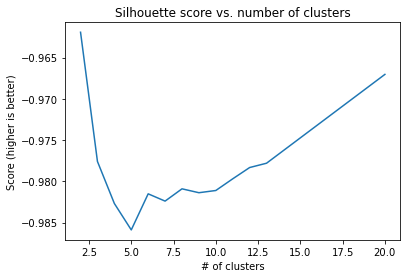

In [33]:
np.fill_diagonal(dist, 0)
_ = silhouette_k(dist, linkage_matrix)

 # Hierarchical Clustering Using Jaccard Coefficient and IDF

In [34]:
def calc_DF(tfDict):
    count_DF = {}
    # Run through each document's tf dictionary and increment countDict's (term, doc) pair
    for document in tfDict:
        for term in document:
            if term in count_DF:
                count_DF[term] += 1
            else:
                count_DF[term] = 1
    return count_DF

DF = calc_DF(listOfSummary)
DF

{('dev',): 104,
 ('demo',): 330,
 ('portal',): 591,
 ('edit',): 78,
 ('bundle',): 26,
 ('items',): 45,
 ('add',): 161,
 ('item',): 198,
 ('type',): 71,
 ('code',): 134,
 ('season',): 2,
 ('subscription',): 117,
 ('return',): 59,
 ('error',): 269,
 ('response',): 39,
 ('issue',): 193,
 ('occur',): 126,
 ('new',): 167,
 ('already',): 69,
 ('create',): 190,
 ('draft',): 42,
 ('store',): 182,
 ('view',): 52,
 ('please',): 110,
 ('notice',): 134,
 ('note',): 97,
 ('also',): 55,
 ('provide',): 7,
 ('suitable',): 1,
 ('message',): 156,
 ('one',): 46,
 ('show',): 139,
 ('fail',): 125,
 ('update',): 182,
 ('try',): 113,
 ('accountid',): 24,
 ('see',): 101,
 ('attachment',): 75,
 ('detail',): 134,
 ('dev', 'demo'): 15,
 ('demo', 'portal'): 3,
 ('portal', 'edit'): 1,
 ('edit', 'bundle'): 1,
 ('bundle', 'items'): 6,
 ('items', 'add'): 1,
 ('add', 'item'): 12,
 ('item', 'type'): 10,
 ('type', 'code'): 4,
 ('code', 'season'): 2,
 ('season', 'subscription'): 2,
 ('subscription', 'return'): 2,
 ('retu

In [35]:
with open('./Output/MyDFDict.csv', 'w') as f:
    for key in DF.keys():
        f.write("%s,%s\n"%(key,DF[key]))

In [36]:
n_document = len(listOfSummary)

def calc_IDF(__n_document, __DF):
    IDF_Dict = {}
    for term in __DF:
        IDF_Dict[term] = np.log(__n_document / (__DF[term] + 1))
    return IDF_Dict
  
#Stores the idf dictionary
IDF = calc_IDF(n_document, DF)

In [37]:
with open('./Output/MyIDFDict.csv', 'w') as f:
    for key in IDF.keys():
        f.write("%s,%s\n"%(key,IDF[key]))

In [38]:
def compute_jaccard(str1, str2):
    himpunan1 = set(str1)
    himpunan2 = set(str2)
    irisan = himpunan1.intersection(himpunan2)
    IDF_VAL = 0.0
    for key in irisan:
        IDF_VAL = IDF_VAL + IDF[key]
    IDF_VAL = IDF_VAL/(len(irisan)+1)
    gabungan = himpunan1.union(himpunan2)
#     jaccard = IDF_VAL
    jaccard = (len(irisan)/float(len(gabungan))) * IDF_VAL
    
    return jaccard

In [39]:
import itertools

sim_df = pd.DataFrame()

for col_pair in itertools.combinations_with_replacement(listOfSummary,2):
    strOfCol = str(col_pair)
    
    u0 = col_pair[0]
    u1 = col_pair[1]
    sim_df.loc[str(col_pair[0]), str(col_pair[1])] = compute_jaccard(u0, u1)

In [40]:
sim_df = sim_df.fillna(0)

In [41]:
dist = np.array(sim_df)

print(dist)

[[3.54419121e+00 2.96009946e-01 2.02921430e-02 ... 2.64561350e-02
  4.54590716e-02 2.87141734e-02]
 [0.00000000e+00 3.37874723e+00 4.02154493e-02 ... 3.65575684e-02
  4.80074014e-02 3.75904407e-03]
 [0.00000000e+00 0.00000000e+00 4.50476434e+00 ... 1.18333416e-02
  2.32492527e-02 3.54921003e-02]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.76130488e+00
  5.92670225e-01 1.43396644e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  3.86151648e+00 1.27650302e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 4.32428754e+00]]


In [42]:
sim_df.to_csv("./Output/jcidf_matrix.csv")

## Agglomerative Hierarchical Clustering

In [43]:
linkage_matrix = weighted(dist) # replace with complete, single, or other scipy.cluster.hierarchical algorithms

## Visualization

Dendrogram visualization. We visualize the titles of each paper next to the corresponding leaf to qualitatively evaluate the clustering.

Changing the `color_threshold` kwarg in the call to `dendrogram()` will affect how the clusters are displayed by increasing or decreasing the 
minimum distance necessary for `dendrogram()` to color a cluster differently.

In [44]:
# sys.setrecursionlimit(10000)
# MAX_COPHENETIC_DIST = max(linkage_matrix[:,2]) * 0.39 # max distance between points to be considered together. can be tuned.
# MAX_TITLE_LEN = 200

# fig, ax = plt.subplots(figsize=(15, 80)) # set size
# ax = dendrogram(linkage_matrix, orientation="right", color_threshold=MAX_COPHENETIC_DIST, leaf_font_size=4,
#                 labels=Summary.apply(lambda x: x if len(x) < MAX_TITLE_LEN else x[:MAX_TITLE_LEN  - 3] + "...").tolist())

# plt.tick_params(axis= 'x', which='both',  bottom='off', top='off',labelbottom='off')

# plt.tight_layout() #show plot with tight layout
# plt.savefig('./Output/jaccard-idf-coeff-ward.png', dpi=300)

# Analysis

We now take the raw clusters achieved and use the silhouette score and elbow method to evaluate.

In [45]:
def silhouette_k(distance_matrix, linkage_matrix, max_k=20):
    scores = []
    for i in range(2, max_k+1):
        clusters = fcluster(linkage_matrix, i, criterion='maxclust')
        score = silhouette_score(distance_matrix, clusters, metric='precomputed')
        print("Silhouette score with {} clusters:".format(i), score)
        scores.append(score)
    plt.title("Silhouette score vs. number of clusters")
    plt.xlabel("# of clusters")
    plt.ylabel("Score (higher is better)")
    plt.plot(np.arange(2, max_k+1), scores)
    plt.show()
    return scores

Silhouette score with 2 clusters: -0.6715210624945712
Silhouette score with 3 clusters: -0.8715410416412999
Silhouette score with 4 clusters: -0.9886516489639934
Silhouette score with 5 clusters: -0.9881813988009783
Silhouette score with 6 clusters: -0.9866336728083357
Silhouette score with 7 clusters: -0.9861355800218182
Silhouette score with 8 clusters: -0.9845979770855484
Silhouette score with 9 clusters: -0.9830500159365885
Silhouette score with 10 clusters: -0.9843447646946788
Silhouette score with 11 clusters: -0.9828065136872659
Silhouette score with 12 clusters: -0.9812898711842133
Silhouette score with 13 clusters: -0.9797514096457518
Silhouette score with 14 clusters: -0.9782132670751155
Silhouette score with 15 clusters: -0.9766747737914705
Silhouette score with 16 clusters: -0.9751357789188448
Silhouette score with 17 clusters: -0.973814566962985
Silhouette score with 18 clusters: -0.9722760765338804
Silhouette score with 19 clusters: -0.9707376456204863
Silhouette score wi

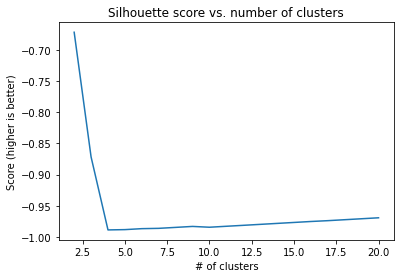

In [46]:
np.fill_diagonal(dist, 0)
_ = silhouette_k(dist, linkage_matrix)